In [0]:
import ast
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [0]:
data = pd.read_csv('drive/My Drive/treject/train.csv')

Amount of data is 1710670 records..

In [0]:
data.dtypes

TRIP_ID           int64
CALL_TYPE        object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID           int64
TIMESTAMP         int64
DAY_TYPE         object
MISSING_DATA       bool
POLYLINE         object
dtype: object

In [0]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


### Removing some data points (to save some processing time, and to clean some data points)

There are some trips that do not have a record for some reason .. Get rid of those 

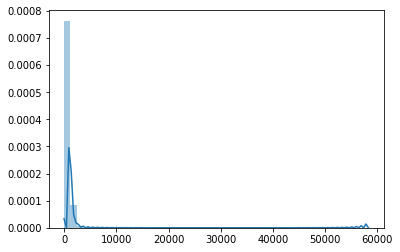

In [0]:
data = data[data.POLYLINE != '[]']
travel_time = [15*len(ast.literal_eval(record)) for record in data.POLYLINE]
data = data.reset_index()
sns.distplot(travel_time)

In [0]:
np.quantile(travel_time, .05)

195.0

In [0]:
np.quantile(travel_time, .99)

2835.0

taking only rides that lasted between 195 to 2835  seconds (which is roughly between 3 to 47 minutes)

In [0]:
data['RIDE_DURATION'] = travel_time
data = data[data.RIDE_DURATION <= 2835 ]
data = data[data.RIDE_DURATION >= 195 ]

### **Dealing with time**

In [0]:
data = data.reset_index()
all_dates = (datetime.datetime.utcfromtimestamp(data.TIMESTAMP[i]).strftime('%Y-%m-%d %H:%M:%S') for i in range(len(data)))
all_dates = [str(i) for i in all_dates]
data['TIME'] = all_dates

Breaking time down to;



*   week of year
*   day of week
*   quarter hour of the day



In [0]:
# example of what I mean .. random example
print(data['TIME'][0])
a = datetime.datetime.strptime(data['TIME'][0], "%Y-%m-%d %H:%M:%S")
print('week of the year: {}'.format(a.isocalendar()[1])) # week of year
print('day of the week.. its a wed, where monday = 0: {}'.format(a.weekday())) # day of week
print('quarter hour of the day: {}'.format(a.hour * 4 + np.floor(a.minute / 15))) # quarter hour of the day
print('now running above for every row and adding to dataframe..')

# if resources are limited please run in a single loop
# used list comprehension in order to express clearly 
week_of_year = [datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S").isocalendar()[1] 
                for time in data['TIME']]
day_of_week  = [datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S").weekday() 
                for time in data['TIME']]
quarter_hour = [datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S").hour * 4 + 
                np.floor(datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S").minute / 15) 
                for time in data['TIME']]

data['WEEK_OF_YEAR'] = week_of_year
data['DAY_OF_WEEK'] = day_of_week
data['QUARTER_HOUR'] = quarter_hour

2013-07-01 00:00:58
week of the year: 27
day of the week.. its a wed, where monday = 0: 0
quarter hour of the day: 0.0
now running above for every row and adding to dataframe..


dropping the UNIX Timestamp and pickle dataframe

In [0]:
data = data.drop(['TIMESTAMP'], axis = 1)
# getting rid of extra index columns
data = data.iloc[:, 2:]

### Clustering

Taking all the last points of the Polylines as destinations.

In [0]:
# get all last points in polylines

destinations = [ast.literal_eval(line)[-1] for line in (data.POLYLINE)]
# these will be the labels for the network so save them for later use
pickle.dump(destinations,open('drive/My Drive/treject/destinations.pkl','wb'))

aiming to classify what point each vehical ends up at. So we take only the last points (destination points) for all of the trips in the polyline. We then use mean shift clustering in order to give each destination a categorical label. 

The MeanShift implimentation of Sklearn requires a bandwith argument. If left this argument is not initialized, this rerouts the data you've input into;

```
sklearn.cluster.estimate_bandwidth
```

This method does not scale well, it will cause a major bottle neck with large amounts of data, therefore it is recommended that you manually get the bandwidth with a *subset of your data* before going into the Meanshift alg.

We sample 500000 destinations, and set a low quantile to get a bandwith that provides a reasonable amount of clusters.

Below one can see two visualizations;

* Cluster centers
* Cluster centers overlaying all desitnations 

To further prevent overhead, we round the coordinates down to the 4th decimal place (~10 meters). 

In [0]:
destinations = [[round(x[0], 4), round(x[1], 4)] for x in destinations]
sample_points = sample(destinations, 500000)
bandwidth = estimate_bandwidth(sample_points, quantile=0.0002)
print('bandwidth: {}'.format(bandwidth))   

bandwidth: 0.0009372213608152988


In [0]:
clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample_points)

In [0]:
print('number of clusters found: {}'.format(len(clustering.cluster_centers_)))

number of clusters found: 6481


Plotting the clusters

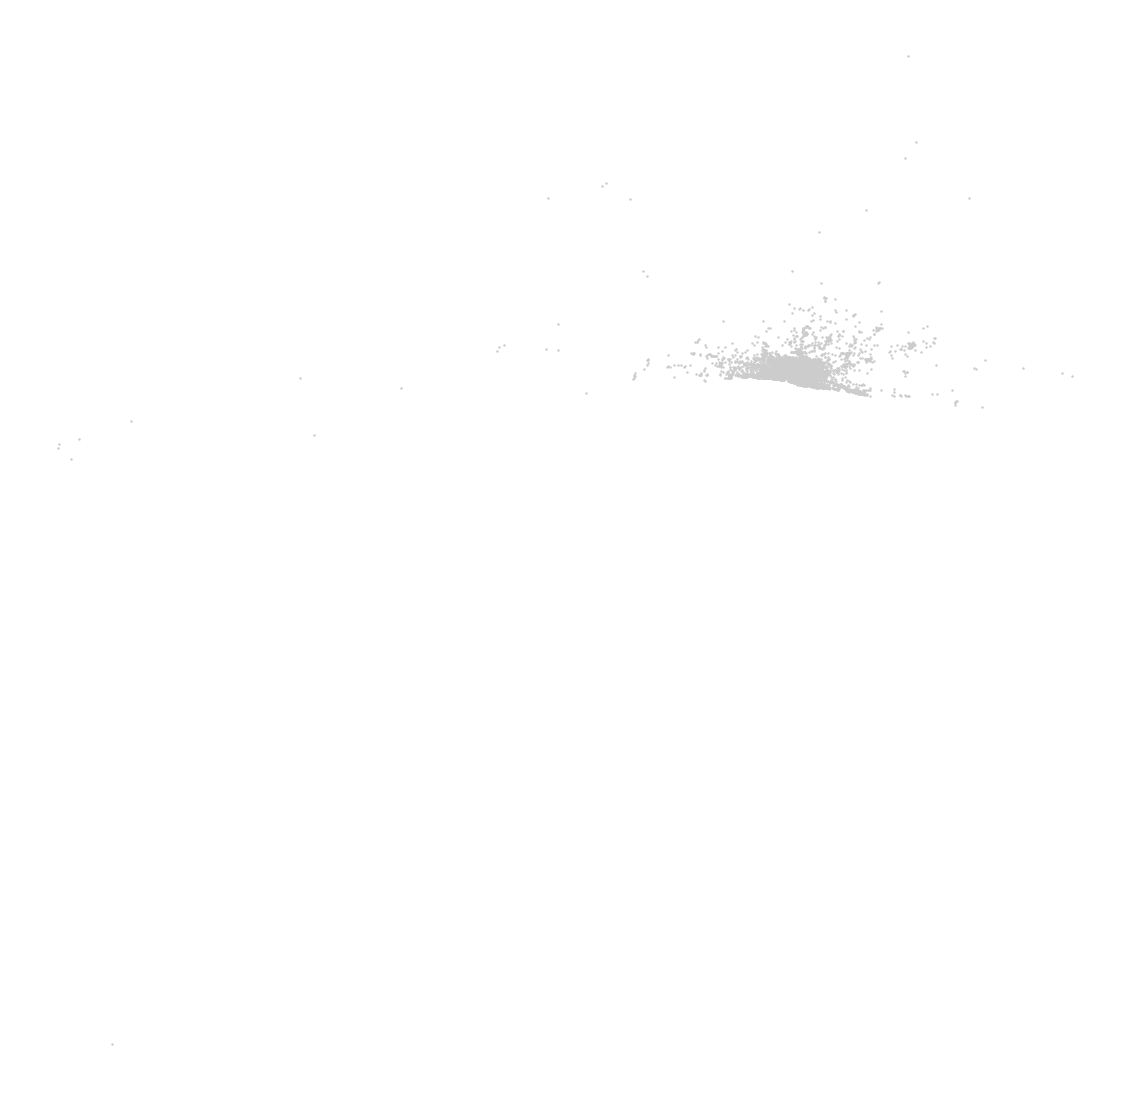

In [0]:
plt.figure(figsize=(20,20))
plt.scatter(clustering.cluster_centers_[:,1], clustering.cluster_centers_[:,0], c='#cccccc', s=2)
plt.axis('off')
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().autoscale_view('tight')

Plotting the clusters over the actual destination points

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


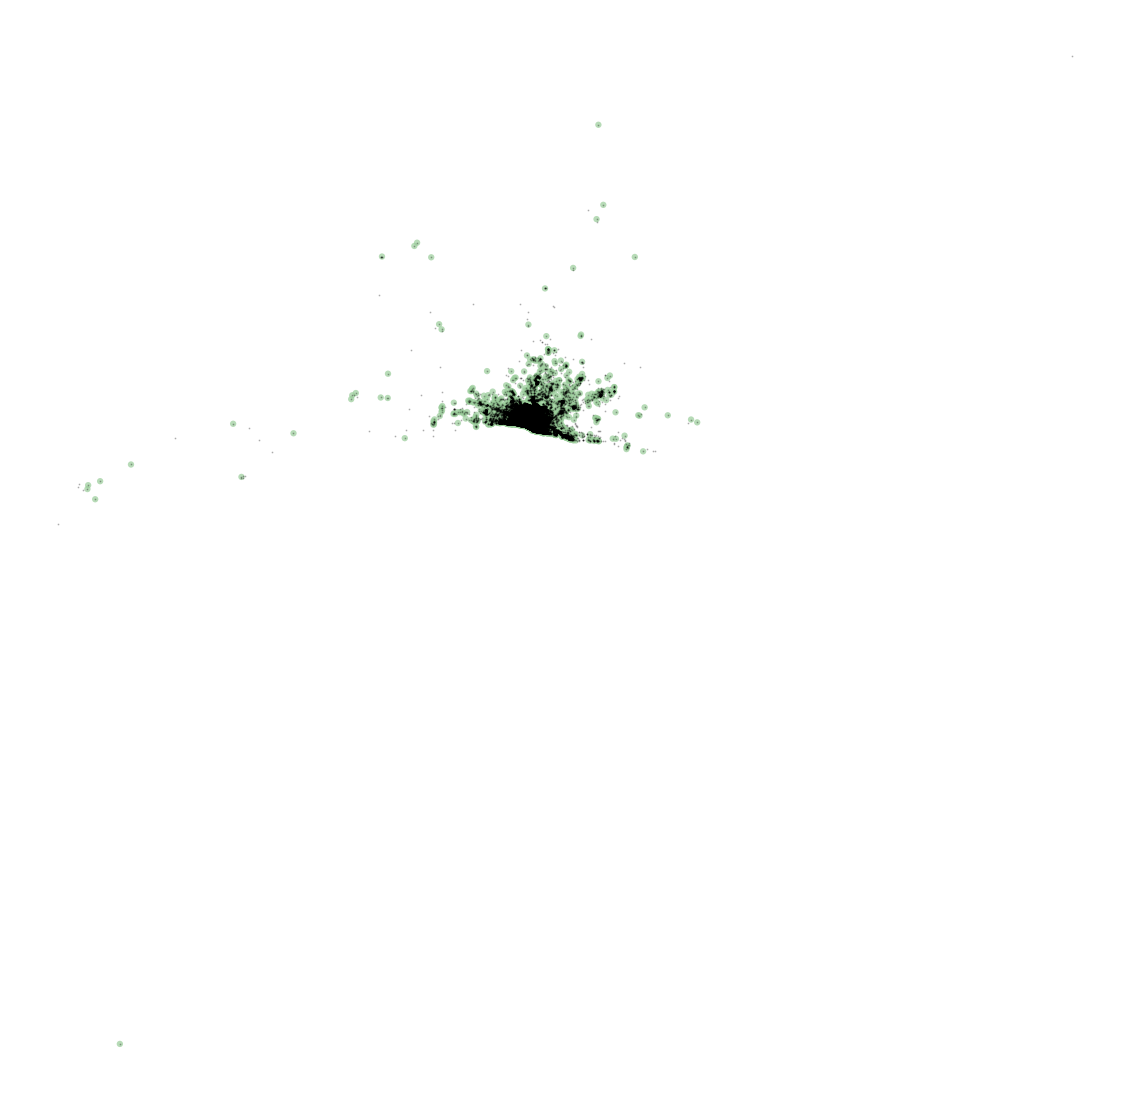

In [0]:
plt.figure(figsize=(20,20))
plt.scatter(clustering.cluster_centers_[:,1], clustering.cluster_centers_[:,0], c='#99cc99', edgecolor='None', alpha=0.7, s=40)
plt.scatter(np.array(destinations)[:,1], np.array(destinations)[:,0], c='k', alpha=0.2, s=1)
plt.grid('off')
plt.axis('off')
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().autoscale_view('tight')

In [0]:
# save cluster centers
np.savetxt('drive/My Drive/treject/cluster_centers.txt', clustering.cluster_centers_)

### Generating Categorical Data and Disassembling the Polyline 

We are going to be using the first and last 5 points on the polyline as features in our MLP.

Secondly we need to process the metadata in embedding layers, to make that process run smoothly, we will turn the meta in the dataframe to categorical. 

creating 20 new features ... lat1, lng1, lat2, lng2, lat3 ..., lng10 
and creating targets

In [0]:
lat1 = []
lat2 = []
lat3 = []
lat3 = []
lat4 = []
lat5 = []
lat6 = []
lat7 = []
lat8 = []
lat9 = []
lat10 = []
lng1 = []
lng2 = []
lng3 = []
lng4 = []
lng5 = []
lng6 = []
lng7 = []
lng8 = []
lng9 = []
lng10 = []
target_lat = []
target_lng = []

for line in data.POLYLINE:
  
  i = ast.literal_eval(line)
  
  lat1.append(i[0][0])
  lat2.append(i[1][0])
  lat3.append(i[2][0])
  lat4.append(i[3][0])
  lat5.append(i[4][0])
  lat6.append(i[-6][0])
  lat7.append(i[-5][0])
  lat8.append(i[-4][0])
  lat9.append(i[-3][0])
  lat10.append(i[-2][0])
  lng1.append(i[0][1])
  lng2.append(i[1][1])
  lng3.append(i[2][1])
  lng4.append(i[3][1])
  lng5.append(i[4][1])
  lng6.append(i[-6][1])
  lng7.append(i[-5][1])
  lng8.append(i[-4][1])
  lng9.append(i[-3][1])
  lng10.append(i[-2][1])
  target_lat.append(i[-1][0])
  target_lng.append(i[-1][1])

In [0]:
data['LAT_1'] = lat1
data['LAT_2'] = lat2
data['LAT_3'] = lat3
data['LAT_4'] = lat4
data['LAT_5'] = lat5
data['LAT_6'] = lat6
data['LAT_7'] = lat7
data['LAT_8'] = lat8
data['LAT_9'] = lat9
data['LAT_10'] = lat10
######################
data['LNG_1'] = lng1
data['LNG_2'] = lng2
data['LNG_3'] = lng3
data['LNG_4'] = lng4
data['LNG_5'] = lng5
data['LNG_6'] = lng6
data['LNG_7'] = lng7
data['LNG_8'] = lng8
data['LNG_9'] = lng9
data['LNG_10'] = lng10
######################
data['TARGET_LAT'] = target_lat
data['TARGET_LNG'] = target_lng

In [0]:
# categorizing meta data
data = data.fillna(0)
data.ORIGIN_CALL = pd.Categorical(data.ORIGIN_CALL)
data.ORIGIN_STAND = pd.Categorical(data.ORIGIN_STAND)
data.TAXI_ID = pd.Categorical(data.TAXI_ID)
data.DAY_TYPE = pd.Categorical(data.DAY_TYPE)
data.CALL_TYPE = pd.Categorical(data.CALL_TYPE)

data.ORIGIN_CALL = data.ORIGIN_CALL.cat.codes
data.ORIGIN_STAND = data.ORIGIN_STAND.cat.codes
data.TAXI_ID = data.TAXI_ID.cat.codes
data.DAY_TYPE = data.DAY_TYPE.cat.codes
data.CALL_TYPE = data.CALL_TYPE.cat.codes

In [0]:
# saving the features 
data.to_pickle('drive/My Drive/treject/mlp_feed.pkl')